In [1]:
import numpy as np

In [2]:
# try orthogonalizing AO and going to MO!
aux = np.load('ke+en+overlap+ee_twoe+dip_hf_s0_h2_sto-3g.npz')

In [3]:
s = aux['overlap_data']
sevals, sevecs = np.linalg.eigh(s)
xmat = sevecs @ np.diag(sevals**(-0.5))

In [4]:
NSim=4
densCI = np.zeros((NSim,NSim,2,2))
for i in range(NSim):
    for j in range(i,NSim):
        filename = 'dens_ci_'+str(i)+'_'+str(j)+'.npz'
        dens = np.load(filename, allow_pickle=True)['arr_0']
        # densCI[i,j,:,:] = dens 
        densCI[i,j,:,:] = np.diag(sevals**(0.5)) @ sevecs.T @ dens @ sevecs @ np.diag(sevals**(0.5))

In [5]:
ppairsR = [(0,0), (0,2), (0,3), (2,2), (2,3), (3,3)]
ppairsI = [(0,2), (0,3), (2,3)]
qpairsR = [(0,0), (0,1), (1,1)]
qpairsI = [(0,1)]

tq = len(qpairsR) + len(qpairsI)
tp = len(ppairsR) + len(ppairsI)

print(tp)

9


In [6]:
hvec = np.array([0.,0.60651041,0.9689314,1.62042649])
delta = 0.008268

In [7]:
past = 2
m = np.zeros((tq*(past+1),tp),dtype=np.complex128)
for i in range(len(qpairsR)):
    for j in range(len(ppairsR)):
        qp = qpairsR[i]
        pp = ppairsR[j]
        if pp[0]==pp[1]:
            m[i,j] = densCI[pp[0],pp[1],qp[0],qp[1]]
            for kk in range(1, past+1):
                m[i+kk*tq,j] = m[i,j]
        else:
            m[i,j] = densCI[pp[0],pp[1],qp[0],qp[1]] + densCI[pp[0],pp[1],qp[1],qp[0]]
            
            othj = len(ppairsR) + ppairsI.index(pp)
            
            for kk in range(1, past+1):
                fac = np.exp(1j*(hvec[pp[0]]-hvec[pp[1]])*kk*delta)
                rfac = np.real(fac)
                ifac = np.imag(fac)
                m[i+kk*tq,j] = rfac*m[i,j]
                m[i+kk*tq,othj] = -ifac*m[i,j]
            
for i in range(len(qpairsI)):
    for j in range(len(ppairsI)):
        qp = qpairsI[i]
        pp = ppairsI[j]
        m[i + len(qpairsR), j + len(ppairsR)] = densCI[pp[0],pp[1],qp[0],qp[1]] - densCI[pp[0],pp[1],qp[1],qp[0]]
        
        othj = ppairsR.index(pp)

        for k in range(1,past+1):
            fac = np.exp(1j*(hvec[pp[0]]-hvec[pp[1]])*k*delta)
            rfac = np.real(fac)
            ifac = np.imag(fac)
            m[i + len(qpairsR) + k*tq, j + len(ppairsR)] = rfac*m[i + len(qpairsR), j + len(ppairsR)]
            m[i + len(qpairsR) + k*tq, othj] = ifac*m[i + len(qpairsR), j + len(ppairsR)]

m /= 2.0

morig = np.copy(m)

m0 = np.copy(m[:,0])
m[:,3] -= m[:,0]
m[:,5] -= m[:,0]


In [8]:
print(m.shape)

print(np.linalg.svd(m)[1])

myind = np.array([0,1,3,4,5,7,8,10])
print(np.abs(np.linalg.eig(m[myind,1:])[0]))

(12, 9)
[6.21283445e+00 2.44973330e+00 2.40392638e+00 7.69796479e-01
 9.61517523e-03 8.99508899e-04 5.87029314e-04 3.42577566e-05
 1.46576856e-16]
[1.31348693e+00 1.31348693e+00 1.36633896e+00 1.62058619e-02
 1.62058619e-02 2.65382836e-03 9.35281281e-07 6.96534934e-08]


In [9]:
goodm = m[ myind, : ]
goodm = goodm[ :, 1: ]
print(goodm.shape)

minv = np.linalg.inv(goodm)

print(np.sum(np.abs(minv @ goodm - np.eye(8))))
print(np.sum(np.abs(goodm @ minv - np.eye(8))))

(8, 8)
3.155880049196585e-06
2.116345234290349e-06


In [10]:
def ptoqfull(pmat):
    pvec = np.zeros(tp, dtype=np.complex128)
    for i in range(len(ppairsR)):
        pp = ppairsR[i]
        pvec[i] = np.real(pmat[pp[0],pp[1]])
    for i in range(len(ppairsI)):
        pp = ppairsI[i]
        pvec[i+len(ppairsR)] = np.imag(pmat[pp[0],pp[1]])
    qvec = morig @ pvec
    return qvec

In [11]:
def ptoq(pmat):
    pvec = np.zeros(tp, dtype=np.complex128)
    for i in range(len(ppairsR)):
        pp = ppairsR[i]
        pvec[i] = np.real(pmat[pp[0],pp[1]])
    for i in range(len(ppairsI)):
        pp = ppairsI[i]
        pvec[i+len(ppairsR)] = np.imag(pmat[pp[0],pp[1]])
    qvec = m[:,1:] @ pvec[1:] + m0
    return qvec

In [12]:
# let q denote a 2x2 1-electron density matrix in the AO basis
# given inputs q(t) and q(t - \Delta t) and q(t - 2*\Delta t)
# this function returns as output p(t), 
# a 4x4 TDCI electron density matrix
# qt --> q(t)
# qtmkdt --> q(t - k \Delta t)

def qtop(qt, **kwargs):
    
    qvec = np.zeros(tq*(past+1), dtype=np.complex128)
    for i in range(len(qpairsR)):
        qp = qpairsR[i]
        qvec[i] = np.real(qt[qp[0],qp[1]])
        for k in range(1, past+1):
            curstr = 'qtm' + str(k) + 'dt'
            qvec[i+k*tq] = np.real(kwargs[curstr][qp[0],qp[1]])
    
    for i in range(len(qpairsI)):
        qp = qpairsI[i]
        qvec[i + len(qpairsR)] = np.imag(qt[qp[0],qp[1]])
        for k in range(1, past+1):
            curstr = 'qtm' + str(k) + 'dt'
            qvec[i+len(qpairsR)+k*tq] = np.imag(kwargs[curstr][qp[0],qp[1]])
    
    tmp = qvec - m0
    pvec = minv @ tmp[myind]
    
    pmat = np.zeros((NSim,NSim),dtype=np.complex128)
    
    for i in range(1, len(ppairsR)):
        pp = ppairsR[i]
        pmat[pp[0], pp[1]] += pvec[i-1]
        if pp[0] != pp[1]:
            pmat[pp[1], pp[0]] += pvec[i-1]
    
    for i in range(len(ppairsI)):
        pp = ppairsI[i]
        pmat[pp[0],pp[1]] += 1j*pvec[i-1 + len(ppairsR)]
        pmat[pp[1],pp[0]] -= 1j*pvec[i-1 + len(ppairsR)]
    
    pmat[0,0] = 1.0 - np.trace(pmat)
    
    return pmat


In [13]:
mypath = './tdcasscf22_h2_sto-3g/outs/'

In [14]:
denTDCI = np.load(mypath + 'denTDCI.npz')['denTDCI']

In [15]:
denAOfile = np.load(mypath + 'td_dens_re+im_tdcasscf22_h2_sto-3g.npz')
denAO = denAOfile['td_dens_re_data'] + 1j*denAOfile['td_dens_im_data']

In [16]:
denMO = np.diag(sevals**(0.5)) @ sevecs.T @ denAO @ sevecs @ np.diag(sevals**(0.5))

In [17]:
err = 0
for j in range(30, 20000):
    r1 = np.concatenate([ np.real(denMO[j].flatten()[np.array([0,1,3])]), 
                          np.imag(denMO[j].flatten()[np.array([1])]) ]) 
    r2 = np.concatenate([ np.real(denMO[j-1].flatten()[np.array([0,1,3])]), 
                          np.imag(denMO[j-1].flatten()[np.array([1])]) ]) 
    r3 = np.concatenate([ np.real(denMO[j-2].flatten()[np.array([0,1,3])]), 
                          np.imag(denMO[j-2].flatten()[np.array([1])]) ]) 
    rmat = np.concatenate([r1,r2,r3])
    err += np.mean(np.abs(rmat - ptoq(denTDCI[j,:,:])))

In [18]:
print(err/(20000-30))

2.3292294196079705e-12


In [19]:
err = 0
for j in range(30, 20000):
    err += np.mean(np.abs(qtop(denMO[j],qtm1dt=denMO[j-1],qtm2dt=denMO[j-2]) - denTDCI[j,:,:]))

In [20]:
print(err/(20000-30)/16)

2.227125221100952e-07


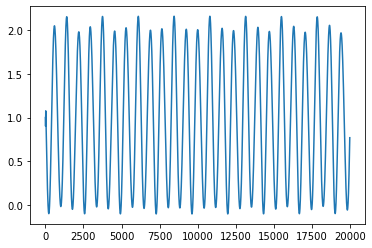

In [21]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.real(np.trace(denMO,axis1=1,axis2=2)))

In [22]:
# propagate 1-electron density matrices using equation with memory
# initial conditions (after forcing has been switched off!)
starttime = 30
lenq = denMO.shape[0] - starttime
qtraj = np.zeros((lenq, 2, 2), dtype=np.complex128)
qtraj[0,:,:] = denMO[30,:,:]
qtraj[1,:,:] = denMO[31,:,:]
qtraj[2,:,:] = denMO[32,:,:]

# simple expressions for U and Uprime because h is diagonal!
U = np.diag(np.exp(-1j*delta*hvec))
Uprime = np.diag(np.exp(-1j*(delta/2.0)*hvec))

for j in range(2, lenq - 1):
    # start by computing p from q
    p = qtop(qtraj[j],qtm1dt=qtraj[j-1],qtm2dt=qtraj[j-2])
    
    if j == 2:
        P_n_min_12 = np.copy(p)
        tdhfrhs = (np.diag(hvec) @ P_n_min_12 - P_n_min_12 @ np.diag(hvec))/(1j)
        P_n = P_n_min_12 + 0.5*delta*tdhfrhs
    else:
        P_n_min_12 = P_n_plus_12
        P_n = P_n_plus_1
    
    P_n_plus_12 = U @ P_n_min_12 @ U.conj().T
    qflat = ptoq(P_n_plus_12)
    qtraj[j+1,:,:] = np.array([qflat[0], qflat[1] + 1j*qflat[3], qflat[1] - 1j*qflat[3], qflat[2]]).reshape((2,2))
    P_n_plus_1 = Uprime @ P_n_plus_12 @ Uprime.conj().T

In [25]:
np.linalg.norm(qtraj - denMO[30:])

1.377704518150175e-05

In [29]:
# given a time series of 1-electron density matrices,
# this function returns a time series of flattened real vectors
def flatden(denseq):
    flatout = []
    for qp in qpairsR:
        flatout.append(np.real(denseq[:,qp[0],qp[1]]))
    for qp in qpairsI:
        flatout.append(np.imag(denseq[:,qp[0],qp[1]]))
    return np.stack(flatout,axis=1)

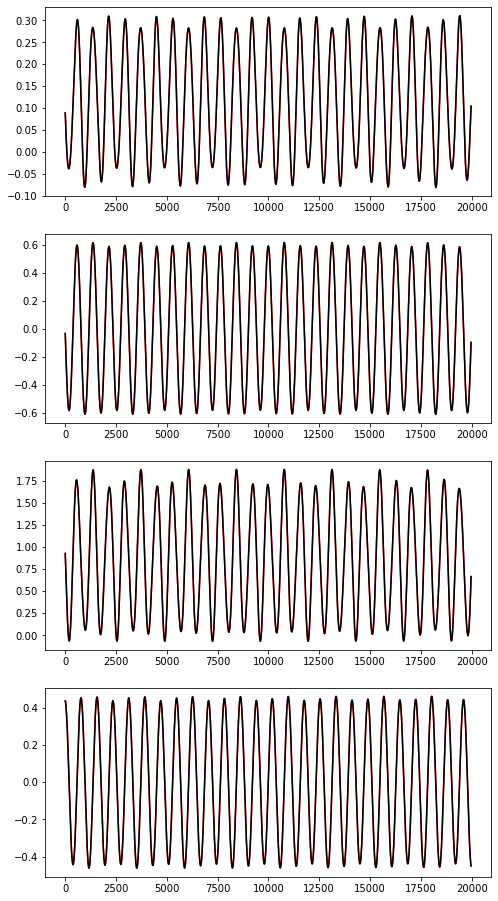

In [38]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

qtrajflat = flatden(qtraj)
denMOflat = flatden(denMO)

for j in range(4):
    axs[j].plot(qtrajflat[:, j], color='red')
    axs[j].plot(denMOflat[30:, j], color='black')

plt.savefig('tdcipropresult.pdf')

